## Appandex: Pandas with Time Series

In [42]:
## import some libs
%matplotlib inline 
import matplotlib.pylab
import numpy as np
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### How to create some time range

In [43]:
## lots of ways 
rng = pd.date_range('2016 Jul 1', periods = 10, freq = 'D')                # generate daily data from 2016jul1 and next 10 days
rng = pd.date_range('2016 Jul 1','7/1/2017' , freq = 'M')                  # monthly data, using start and end date
brng = pd.period_range('2016-01-01 10:10', freq = 'B', periods = 10)       # only want business days 

## example make the index as time series 
pd.Series(range(len(rng)), index = rng)                                    # a sample time series 

2016-07-31     0
2016-08-31     1
2016-09-30     2
2016-10-31     3
2016-11-30     4
2016-12-31     5
2017-01-31     6
2017-02-28     7
2017-03-31     8
2017-04-30     9
2017-05-31    10
2017-06-30    11
Freq: M, dtype: int64

#### Time indexing

In [44]:
## some sample data 
data = pd.read_fwf("http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii", parse_dates = [[0, 1]], infer_datetime_format = True, header = None,)
## rename variables and index them 
data.columns = ['month', 'value']
data.index = data.month
data = data.drop('month', 1)
data.head()

value
month               
1950-01-01 -0.060310
1950-02-01  0.626810
1950-03-01 -0.008128
1950-04-01  0.555100
1950-05-01  0.071577

#### Filter time range , truncate time etc

In [45]:
data['1950-1-11':'1951-11-12']                            # basic filter by range 
data.iloc[0:10:2].index                                     # every other month 
data.iloc[[1,2,3]].index                                    # specific rows of data
data[data.index<'1951-1-12']                              # filter by logic
data.truncate(before='3/31/1950', after='5/31/1950')     # truncate before and after

value
month               
1950-04-01  0.555100
1950-05-01  0.071577

#### Seperate and combine times 

In [46]:
df_time =pd.DataFrame([data.index.year,data.index.month,data.index.day],index=['year','month','day']).T
df_time.head(2)

year  month  day
0  1950      1    1
1  1950      2    1

In [47]:
df_time = pd.to_datetime(df_time[['year', 'month', 'day']])
df_time.head(2)

0   1950-01-01
1   1950-02-01
dtype: datetime64[ns]

#### Resample, same as collapse in stata

In [48]:
## collapse by month, quarter , year 
data.resample('M').sum().head(2)
data.resample('Q').min().head(2)
data.resample('A').max().head(2)

value
month              
1950-12-31  0.62681
1951-12-31  1.98720

### Lags functions

In [49]:
## create some data
df = pd.DataFrame(np.random.randn(200, 3), index = pd.date_range('7/1/2016', freq = 'D', periods = 200), columns = ['A', 'B', 'C'])
df.head(2)

A         B         C
2016-07-01 -0.441682 -0.574827  1.823038
2016-07-02  0.662442 -0.753787  1.549854

In [50]:
## use shift to create lags 
df['l.A'] = df.A.shift(1)
df['l2.A'] = df.A.shift(2)
df.head(3)

A         B         C       l.A      l2.A
2016-07-01 -0.441682 -0.574827  1.823038       NaN       NaN
2016-07-02  0.662442 -0.753787  1.549854 -0.441682       NaN
2016-07-03 -0.425097 -0.451548  0.608338  0.662442 -0.441682

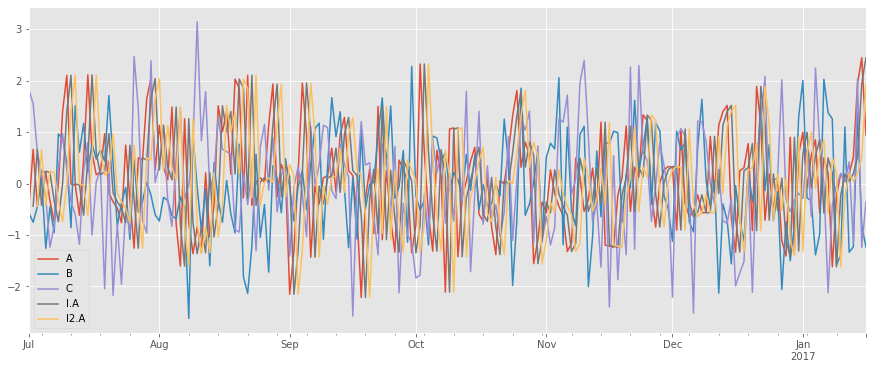

In [51]:
df.plot()

### Rolling windows functions

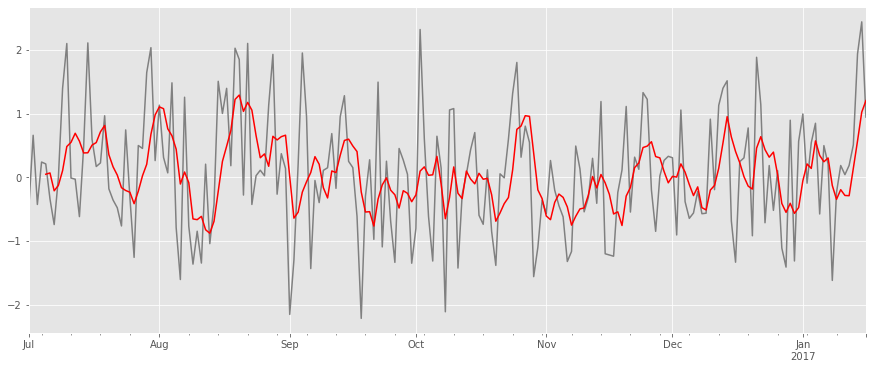

In [52]:
#pd.rolling_mean(df, window = 2)[1:10] # in future versions you want to resample separately
r = df.rolling(window = 5)
#r.agg, r.apply, r.count, r.exclusions, r.max, r.median, r.name, r.quantile, r.kurt, r.cov, r.corr, r.aggregate, r.std, r.skew, r.sum, r.var
df.A.plot(color ='gray')
r.mean()['A'].plot(color = 'red')

In [58]:
## get the rolling sum and mean using agg functions
r.A.agg(['sum','mean']).head(5)

sum      mean
2016-07-01       NaN       NaN
2016-07-02       NaN       NaN
2016-07-03       NaN       NaN
2016-07-04       NaN       NaN
2016-07-05  0.249529  0.049906

More compacked code

In [57]:
df['A-rolling-mean'] = df['A'].rolling(window=5).mean()
df.head()

A         B         C       l.A      l2.A  A-rolling-mean
2016-07-01 -0.441682 -0.574827  1.823038       NaN       NaN             NaN
2016-07-02  0.662442 -0.753787  1.549854 -0.441682       NaN             NaN
2016-07-03 -0.425097 -0.451548  0.608338  0.662442 -0.441682             NaN
2016-07-04  0.241671  0.105681  0.191641 -0.425097  0.662442             NaN
2016-07-05  0.212194 -1.261979 -0.281326  0.241671 -0.425097        0.049906

# EWMA
## Exponentially-weighted moving average 

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows)
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
$ y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i} $   (it is really just a weighted average)

When adjust is True (default), weighted averages are calculated using weights:

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When adjust=True we have y0=x0 and from the last representation above we have yt=αxt+(1−α)yt−1, therefore there is an assumption that x0 is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

One must have 0<α≤1, and while since version 0.18.0 it has been possible to pass α directly, it’s often easier to think about either the span, center of mass (com) or half-life of an EW moment:
\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}
 * Span corresponds to what is commonly called an “N-day EW moving average”.
* Center of mass has a more physical interpretation and can be thought of in terms of span: c=(s−1)/2
* Half-life is the period of time for the exponential weight to reduce to one half.
* Alpha specifies the smoothing factor directly.


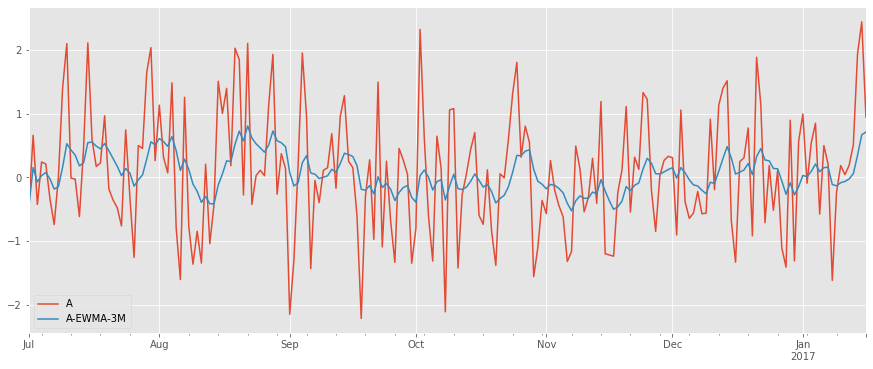

In [63]:
df['A-EWMA-3M']=df.A.ewm(span=12).mean()
df[['A','A-EWMA-3M']].plot()

### Custom rolling window function

In [25]:
## rolling window, calculate mean absolute error 
## remember the thet x we are getting in lambda function is an array with size = to window size
df.rolling(window = 5).apply(lambda x:np.fabs(x - x.mean()).mean()).head(10)     # np.fabs = absolute value

A         B         C       l.A      l2.A
2016-07-01       NaN       NaN       NaN       NaN       NaN
2016-07-02       NaN       NaN       NaN       NaN       NaN
2016-07-03       NaN       NaN       NaN       NaN       NaN
2016-07-04       NaN       NaN       NaN       NaN       NaN
2016-07-05  0.814683  1.085751  0.698544       NaN       NaN
2016-07-06  0.730330  0.906146  0.715003  0.814683       NaN
2016-07-07  0.575703  0.810295  0.658090  0.730330  0.814683
2016-07-08  0.652587  0.854324  0.596387  0.575703  0.730330
2016-07-09  0.748219  0.806865  0.506202  0.652587  0.575703
2016-07-10  0.866033  0.570692  0.190614  0.748219  0.652587

### Expanding windows

In [26]:
# Expanding windows
# Yields the value of the statistic with all the data available up to that point in time
df.expanding(min_periods = 1).mean()[1:5]

A         B         C       l.A      l2.A
2016-07-02 -0.215000 -0.840364  0.405950 -1.301345       NaN
2016-07-03 -0.580345 -0.222953  0.190934 -0.215000 -1.301345
2016-07-04 -0.320820 -0.217885  0.072669 -0.580345 -0.215000
2016-07-05 -0.353804  0.276989  0.461451 -0.320820 -0.580345

## Use some statsmodel functions

##### 1. HP filter

The Hodrick-Prescott filter separates a time-series  y_t  into a trend  τ_t and a cyclical component  ζt

$y_t = \tau_t + \zeta_t$

The components are determined by minimizing the following quadratic loss function

$\min_{\\{ \tau_{t}\\} }\sum_{t}^{T}\zeta_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$

In [31]:
import statsmodels.api as sm

df = sm.datasets.macrodata.load_pandas().data
index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
df.index = index
df.head()

year  quarter   realgdp  realcons  realinv  realgovt  realdpi  \
1959-03-31  1959.0      1.0  2710.349    1707.4  286.898   470.045   1886.9   
1959-06-30  1959.0      2.0  2778.801    1733.7  310.859   481.301   1919.7   
1959-09-30  1959.0      3.0  2775.488    1751.8  289.226   491.260   1916.4   
1959-12-31  1959.0      4.0  2785.204    1753.7  299.356   484.052   1931.3   
1960-03-31  1960.0      1.0  2847.699    1770.5  331.722   462.199   1955.5   

              cpi     m1  tbilrate  unemp      pop  infl  realint  
1959-03-31  28.98  139.7      2.82    5.8  177.146  0.00     0.00  
1959-06-30  29.15  141.7      3.08    5.1  177.830  2.34     0.74  
1959-09-30  29.35  140.5      3.82    5.3  178.657  2.74     1.09  
1959-12-31  29.37  140.0      4.33    5.6  179.386  0.27     4.06  
1960-03-31  29.54  139.6      3.50    5.2  180.007  2.31     1.19

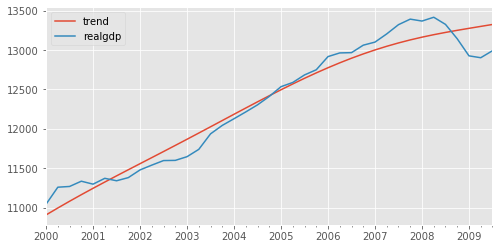

In [35]:
# Tuple unpacking
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(df.realgdp)
df["trend"] = gdp_trend
df[['trend','realgdp']]["2000-03-31":].plot(figsize=(8,4))

##### 2.ETS

We can use an additive model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers). A multiplicative model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of passengers).

Based off this chart, it looks like the trend in these earlier days is slightly increasing at a higher rate than just linear (although it is a  bit hard to tell from this one plot).

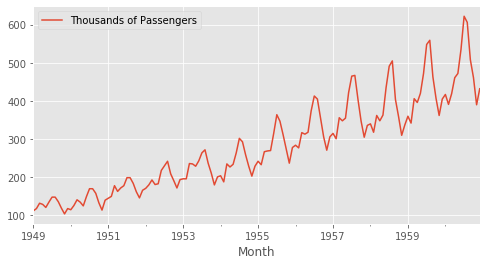

In [67]:
airline = pd.read_csv('data/airline_passengers.csv',index_col="Month")
airline.dropna(inplace=True)
airline.index = pd.to_datetime(airline.index)
airline.plot(figsize=(8,4))

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

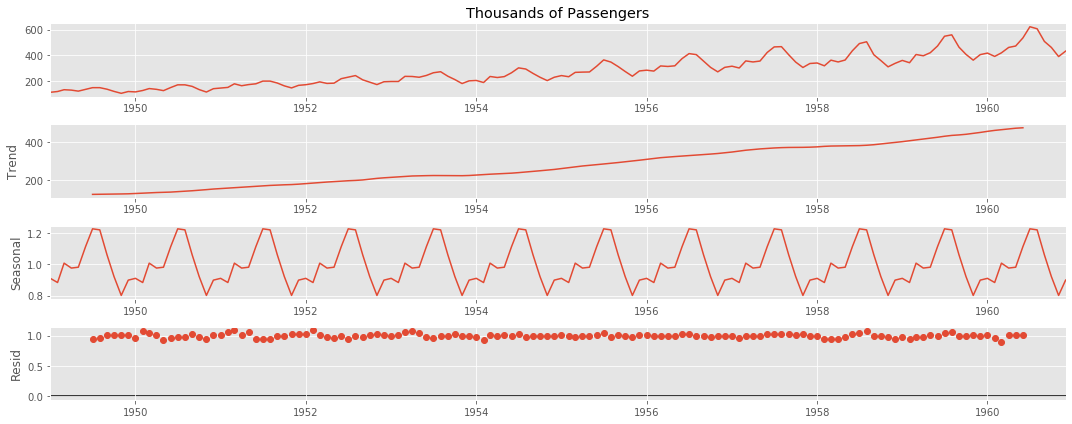

In [78]:
result = seasonal_decompose(airline['Thousands of Passengers'],model='multiplicative')
fig = result.plot()

In [79]:
## components of result object 
seasonal, trend, res = result.seasonal,result.trend,result.resid

In [80]:
seasonal

Month
1949-01-01    0.910230
1949-02-01    0.883625
1949-03-01    1.007366
1949-04-01    0.975906
1949-05-01    0.981378
                ...   
1960-08-01    1.219911
1960-09-01    1.060492
1960-10-01    0.921757
1960-11-01    0.801178
1960-12-01    0.898824
Name: seasonal, Length: 144, dtype: float64